In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
import pickle
import argparse
from collections import Counter
from pycocotools.coco import COCO


class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

def main(caption_path,vocab_path,threshold):
    vocab = build_vocab(json=caption_path, threshold=threshold)
    vocab_path = vocab_path
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)
    print("Total vocabulary size: {}".format(len(vocab)))
    print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

In [ ]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import pickle
import numpy as np
import nltk
from PIL import Image
import pandas as pd
import cv2




class FlickrDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, results, vocab, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            results: annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        
        self.results = results
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        train_captions = pd.read_csv(self.results, delimiter=',')
        vocab = self.vocab
        caption = train_captions['caption'][index]
        img_id =train_captions["image"][index]
        image = Image.open(self.root+'/'+img_id).convert('RGB')
              
        
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        train_captions = pd.read_csv(self.results, delimiter=',')
        captions = train_captions['caption']
        return len(captions)


def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

def get_loader(root, results, vocab, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    flickr = FlickrDataset(root=root,
                       results=results,
                       vocab=vocab,
                       transform=transform)
    train_len = int(0.7*len(flickr))
    valid_len = len(flickr) - train_len
    train_dataset, test_dataset = torch.utils.data.random_split(flickr, [train_len , valid_len])
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    data_loader_train = torch.utils.data.DataLoader(dataset=train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    
    data_loader_val = torch.utils.data.DataLoader(dataset=test_dataset, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader_train, data_loader_val


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [ ]:
import argparse
import torch
import torch.nn as nn
import numpy as np
import os
import pickle

from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_losses, val_losses = [], []

def train(model_path,crop_size,vocab_path,image_dir,caption_path,log_step,save_step,embed_size,hidden_size,num_layers,num_epochs,batch_size,num_workers,learning_rate):
    # Create model directory
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    
    # Image preprocessing, normalization for the pretrained resnet
    transform = transforms.Compose([ 
        transforms.RandomCrop(crop_size),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    
    # Build data loader
    data_loader_train, data_loader_val = get_loader(image_dir,                                          
                                                    caption_path,                                          
                                                    vocab, 
                                                    transform, batch_size,
                                                    shuffle=True, num_workers=num_workers) 

    # Build the models
    encoder = EncoderCNN(embed_size).to(device)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)
    
    # Train the models
    total_step_train = len(data_loader_train) 
    total_step_val = len(data_loader_val)
    train_sum, val_sum = 0, 0
    for epoch in range(num_epochs):
        for i, (images, captions, lengths) in enumerate(data_loader_train):
            
            # Set mini-batch dataset
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            
            # Forward, backward and optimize
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            train_loss = criterion(outputs, targets)
            if i==0 and epoch==0:
            	train_losses.append(float(train_loss))
             
            train_sum += float(train_loss)
            decoder.zero_grad()
            encoder.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            # Save the model checkpoints
            if (i+1) % save_step == 0:
                torch.save(decoder.state_dict(), os.path.join(
                    model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
                torch.save(encoder.state_dict(), os.path.join(
                    model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))
                
            # Print log info
            if i % log_step == 0:
                print('Epoch [{}/{}], Train_Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch, num_epochs, i, total_step_train,
                              train_loss.item(), np.exp(train_loss.item()))) 
            
            
        for i, (images, captions, lengths) in enumerate(data_loader_val):

            # Set mini-batch dataset
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            
            # Forward, backward and optimize
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            val_loss = criterion(outputs, targets)
            
            val_sum += float(val_loss)
            
            # Print log info
            if i % log_step == 0:
                print('Epoch [{}/{}], Validation_Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch, num_epochs, i, total_step_val, 
                              val_loss.item(), np.exp(val_loss.item()))) 
        
        train_losses.append(float(train_sum/total_step_train))
        val_losses.append(float(val_sum/total_step_val))
        train_sum, val_sum = 0, 0
        print(train_losses, val_losses)




In [ ]:
print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
device = torch.device('cuda')

In [ ]:
train(model_path='/content/drive/MyDrive/flickr30k/models8kresnet',
      crop_size=224,
      vocab_path='/content/drive/MyDrive/flickr30k/vocab.pkl',
      image_dir='/content/drive/MyDrive/flickr30k/resized',
      caption_path='/content/drive/MyDrive/flickr30k/results.csv',
      log_step=100,
      save_step=220,
      embed_size=256,
      hidden_size=512,
      num_layers=1,
      num_epochs=15,
      batch_size=128,
      num_workers=2,
      learning_rate=0.001)

Epoch [0/15], Train_Step [0/222], Loss: 9.2082, Perplexity: 9978.7094
Epoch [0/15], Train_Step [100/222], Loss: 3.7287, Perplexity: 41.6261
Epoch [0/15], Train_Step [200/222], Loss: 3.1053, Perplexity: 22.3162
Epoch [0/15], Validation_Step [0/95], Loss: 3.2160, Perplexity: 24.9294
[9.208209037780762, 3.914616575112214] [3.160512678246749]
Epoch [1/15], Train_Step [0/222], Loss: 3.0893, Perplexity: 21.9609
Epoch [1/15], Train_Step [100/222], Loss: 2.9673, Perplexity: 19.4400
Epoch [1/15], Train_Step [200/222], Loss: 2.8163, Perplexity: 16.7152
Epoch [1/15], Validation_Step [0/95], Loss: 2.8284, Perplexity: 16.9187
[9.208209037780762, 3.914616575112214, 2.9511588865572267] [3.160512678246749, 2.86416066069352]
Epoch [2/15], Train_Step [0/222], Loss: 2.7140, Perplexity: 15.0893
Epoch [2/15], Train_Step [100/222], Loss: 2.7418, Perplexity: 15.5145
Epoch [2/15], Train_Step [200/222], Loss: 2.5668, Perplexity: 13.0242
Epoch [2/15], Validation_Step [0/95], Loss: 2.7162, Perplexity: 15.1233
[9

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torchvision import transforms 
import matplotlib.image as mpimg
from PIL import Image


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

def test(vocab_path,embed_size,hidden_size,num_layers,encoder_path,decoder_path,image):
    # Image preprocessing
    img = mpimg.imread(image)
    imgplot = plt.imshow(img)
    plt.show()

    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Build models
    encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Load the trained model parameters
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))

    # Prepare an image
    image = load_image(image, transform)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out the image and the generated caption
    print (sentence)
    

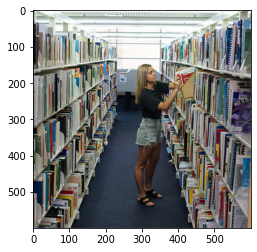

<start> a woman in a green dress walks down the sidewalk . <end>


In [ ]:
test(encoder_path='/content/drive/MyDrive/flickr8k/UE D/models/8k resnet/encoder-15-220.ckpt',
     decoder_path='/content/drive/MyDrive/flickr8k/UE D/models/8k resnet/decoder-15-220.ckpt',
     image='/content/drive/MyDrive/woman_library.jpg',
     vocab_path='/content/drive/MyDrive/flickr8k/vocab.pkl',
     embed_size=256,
     hidden_size=512,
     num_layers=1)

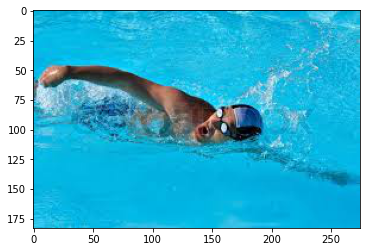

<start> a man in swimming trunks is diving into the ocean . <end>


In [ ]:
test(encoder_path='/content/drive/MyDrive/flickr8k/UE D/models/8k resnet/encoder-15-220.ckpt',
     decoder_path='/content/drive/MyDrive/flickr8k/UE D/models/8k resnet/decoder-15-220.ckpt',
     image='/content/drive/MyDrive/téléchargement (1).jpg',
     vocab_path='/content/drive/MyDrive/flickr8k/vocab.pkl',
     embed_size=256,
     hidden_size=512,
     num_layers=1)